In [1]:
%cd /home/ryoaki374/IMo_perf/

/home/ryoaki374/IMo_perf


In [2]:
import IMo_perf
import matplotlib.pyplot as plt
plt.style.use('./graph_preset.mplstyle')
import numpy as np
import pandas as pd

In [3]:
# Specify the option, size_factor, version and hwp type to load
# If you want to change any values, you can do so by changing the values in the loaded dictionary
# option1_M_flat_v9.dict
option = 1
size_factor = 'M'
version = 'v9'
hwp_type = None

d1 = IMo_perf.temp_IMo.load_dict_rescope(option = option, size_factor=size_factor, version=version, hwp_type=hwp_type)

In [13]:
def to_numpy_tree(tree):
    if isinstance(tree, dict):
        return {k: to_numpy_tree(v) for k, v in tree.items()}
    return np.asarray(tree)


def sensitivity_no_jacobian(d):
    parameters = []
    n = len(d["freq"])
    for iband in range(n):
        d_band = IMo_perf.jaxify.load_band_dict(d, iband) # data clipped by band
        fmin_dib, fmax_dib = IMo_perf.instrument.jaxify_get_dib_edges(d_band)  # [GHz]


        SM = IMo_perf.sky.SkyModel(
        nu_min=fmin_dib,
        nu_max=fmax_dib,
        num=int(1e4),
        fwhm=d["fwhm"][iband],
        components=["CMB", "Gal", "Syn", "OB", "IPD"],
        Iref_type="max",
        )
        # Get spectral radiances [W/m2/sr/Hz] They are stored in a dictionary.
        dInu_sky = SM.build_dInu_sky(dIref=None)


        param = pd.DataFrame(d_band, index=["base_parameters"])
        param["iband"] = iband
        parameters.append(param)

        # Compute sensitivity
        d_band = to_numpy_tree(d_band)  # Convert to numpy array for JAX compatibility mandarory!!!!
        sens = IMo_perf.jaxify.pure_sensitivity(d_band, SM, dInu_sky)
        param["sensitivity"] = sens

    parameters = pd.concat(parameters, ignore_index=True)
    return parameters


In [ ]:
# Compute the sensitivity and the jacobian of the sensitivity using JAX
sens1, jac1, log_jac1 = IMo_perf.jaxify.sensitivity_jacobian(d1)

In [6]:
sens_1  = sensitivity_no_jacobian(d1)

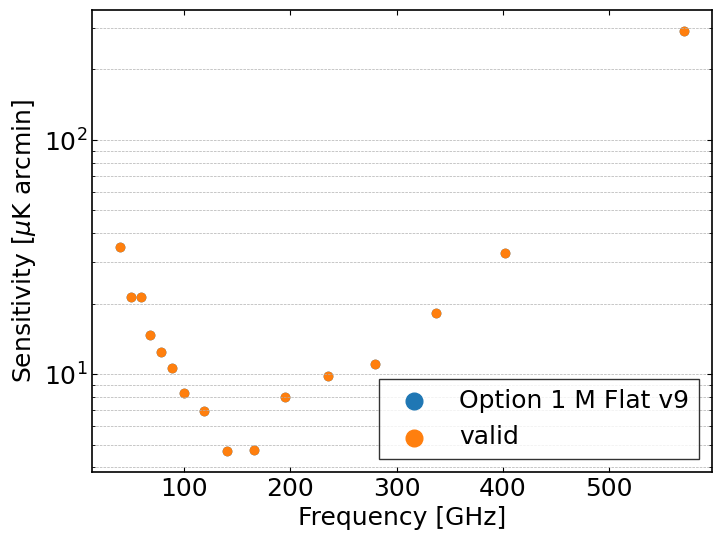

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)

# Plot the sensitivities
ax.scatter(sens1['freq'], sens1['sensitivity'], label='Option 1 M Flat v9', color='tab:blue')
ax.scatter(sens_1['freq'], sens_1['sensitivity'], label='valid', color='tab:orange')
# Set the labels and title
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel(r'Sensitivity [$\mu$K arcmin]')

ax.set_yscale('log')
ax.grid(which='both', linestyle='--', linewidth=0.5, axis='y')
ax.legend(loc='lower right')



In [14]:
# Specify the option, size_factor, version and hwp type to load
# If you want to change any values, you can do so by changing the values in the loaded dictionary d
# option2b_MlHF_flat_v7spill
option = 2
size_factor = 'MlHF'
version = 'v7spill'
hwp_type = 'b' 

d2b = IMo_perf.temp_IMo.load_dict_rescope(option = option, size_factor=size_factor, version=version, hwp_type=hwp_type)

In [16]:
# Compute the sensitivity and the jacobian of the sensitivity using JAX
sens_2b  = sensitivity_no_jacobian(d2b)

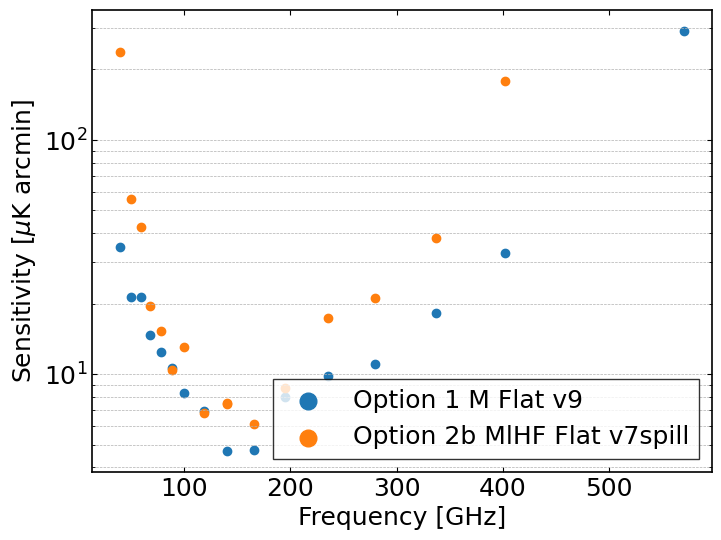

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)

# Plot the sensitivities
ax.scatter(sens_1['freq'], sens_1['sensitivity'], label='Option 1 M Flat v9', color='tab:blue')
ax.scatter(sens_2b['freq'], sens_2b['sensitivity'], label='Option 2b MlHF Flat v7spill', color='tab:orange')
# Set the labels and title
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel(r'Sensitivity [$\mu$K arcmin]')

ax.set_yscale('log')
ax.grid(which='both', linestyle='--', linewidth=0.5, axis='y')
ax.legend(loc='lower right')



In [25]:
# MEMO This is a common pitfall in pandas. When you append a DataFrame to a list

param = pd.DataFrame({"a": [1]}, index=["param_1"])

parameters = []
parameters.append(param) # <-- append reference, not a copy

param["param_2"] = 2      # add new column AFTER the append

result = pd.concat(parameters, ignore_index=True)


from IPython.display import display

display(param, result)      # 1 行で済む

,a,param_2
param_1,1,2


,a,param_2
0,1,2


In [ ]:
# trace the function step by step
print(d1.keys()) # ['T_cmb', 't_obs', 'f_sky', 'DC', 'CR', 'CT', 'T_5K', 'T_2K', 'T_HWP', 'T_01K', 't_fil', 'n_fil', 'tan_fil', 'ref_fil', 'Fil_oob_reject', 'det_yield', 'det_eff', 'Pfac', 'aperture', 'f_number', 'spin_rate', 'names', 'freq', 'band', 'fwhm', 'dpix', 'npix', 'rho', 'rms', 'FP_hood_spillover', 'secondary_mirror_spillover', 'primary_mirror_spillover', 'stop_spillover', 'forebaffle_spillover', 'sky_power', 'HWP_spillover', 'emiss_hwp', 'ref_hwp', 'eff_hwp', 'pol_hwp', 'sens_ref', 'option']

print(d1["names"]) # Frequency band names
print(d1["freq"]) # Frequency band frequencies [GHz]
print(d1["FP_hood_spillover"])
print(d1.items())

d_band = d1.copy()
d_band.pop("names") # namesを消す
d_band["Fil_oob_reject"] = float(d_band["Fil_oob_reject"])

# 1 bandのパラメータを取得
for key, value in d_band.items():
    try:
        d_band[key] = float(value[1])
        print(f"{key}: {d_band[key]}")

    except:
        pass

# value[0] is the value for the first band, value[1] is for the second band, etc.
#freq: 40.0
#band: 0.3
#fwhm: 53.52829
#dpix: 32.0
#npix: 18.0
#FP_hood_spillover: 0.001967
#secondary_mirror_spillover: 0.016273
#primary_mirror_spillover: 0.02684
#stop_spillover: 0.303286
#forebaffle_spillover: 0.003266
#sky_power: 0.648368
#HWP_spillover: 0.0
#emiss_hwp: 0.0
#ref_hwp: 0.0
#eff_hwp: 1.0
#pol_hwp: 1.0
#sens_ref: 27.046410000000005




In [26]:
import jax.numpy as jnp
from jax import value_and_grad

# 1. pure function
def f(d, index):
    return 2*d["a"][index]

# 2. Wrap with value_and_grad to obtain both value and gradient
f_and_gradf = value_and_grad(f)

# 3. Test data
d_ok  = {"a": jnp.array([10.0, 20.0, 30.0])}  # Array → works
d_bad = {"a": 10.0}                           # Scalar → fails

# 4. Good case: array input
val, grad = f_and_gradf(d_ok, 1)
print("OK : value =", val, "grad =", grad)

# 5. Bad case: scalar input triggers TypeError
try:
    f(d_bad, 0)
except TypeError as e:
    print("NG : caught error ->", e)


OK : value = 40.0 grad = {'a': Array([0., 2., 0.], dtype=float64)}
NG : caught error -> 'float' object is not subscriptable
